**Detecção de Fraude – Modelagem com Regressão Logística**

**Descrição do Projeto**

Este projeto utiliza **Regressão Logística** para **detecção de Fraudes em Seguros de Veículos**.  
A técnica é amplamente utilizada em problemas binários e oferece vantagens importantes, como **interpretação estatística**, análise de coeficientes e verificação da contribuição de cada variável para o risco de fraude.

O objetivo é desenvolver um modelo robusto, avaliar seu desempenho e verificar sua aderência aos critérios estatísticos da regressão logística, garantindo confiabilidade para tomada de decisão.

**Objetivo**

Construir um modelo de **Regressão Logística** para classificação binária (fraude vs. não fraude).

Avaliar desempenho por meio de:

- Acurácia
- Precisão
- Recall
- F1-Score
- Matriz de confusão
- Curva ROC e AUC

Interpretar coeficientes e odds ratios para entender como cada variável contribui para aumentar ou reduzir a probabilidade de fraude.

Determinar cutoff ótimo (via Índice de Youden) para equilibrar Sensitividade e Especificidade.

Analisar impacto de erros de classificação:

- Falsos positivos → alertas desnecessários
- Falsos negativos → fraudes que passam despercebidas

**Dataset**

Este conjunto de dados contém informações sobre veículos: atributos, modelo, detalhes de acidentes, etc. Juntamente com detalhes da apólice: tipo de apólice, duração, etc. O objetivo é detectar se uma solicitação de indenização é fraudulenta ou não, variável: FraudFound_P

Dataset: https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection/data

In [ ]:
#Importação dos pacotes necessários

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from scipy.stats import pearsonr
from statstests.process import stepwise
from statstests.tests import shapiro_francia
from scipy.stats import boxcox
from statsmodels.iolib.summary2 import summary_col
#!pip install xlsxwriter

In [3]:
# Função Auxiliar
# Verifica se o modelo de regressão é estatisticamente significativo.
def checar_significancia_modelo(modelo, alpha=0.05):
    """
    Parâmetros:
        modelo : objeto de regressão do statsmodels (ex.: OLS.fit())
        alpha  : nível de significância (default = 0.05)

    Retorna:
        str : mensagem indicando se o modelo é significativo.
    """

    p_valor = modelo.f_pvalue  # p-value do teste F

    if p_valor < alpha:
        return f"O modelo é estatisticamente significativo (p-value = {p_valor:.4e})."
    else:
        return f"O modelo NÃO é estatisticamente significativo (p-value = {p_valor:.4e})."

In [ ]:
# Função Tabela de quantidade (%) para todas as colunas

def resumo_todas_colunas(df):
    resultados = {}

    for col in df.columns:
        # Descrição da coluna
        counts = df[col].value_counts(dropna=False)
        percent = df[col].value_counts(normalize=True, dropna=False) * 100
        
        tabela = pd.DataFrame({
            'quantidade': counts,
            'percentual (%)': percent.round(2)
        })
        
        resultados[col] = tabela
    
    return resultados

In [17]:
#Exportar todas as tabelas (uma por coluna) para Excel

def exportar_resumo_para_excel(resumo_dict, arquivo="resumo.xlsx"):
    with pd.ExcelWriter(arquivo, engine="xlsxwriter") as writer:
        for col, tabela in resumo_dict.items():
            # Nome da aba não pode ter mais que 31 caracteres
            nome_aba = col[:31]
            tabela.to_excel(writer, sheet_name=nome_aba)
    print(f"Arquivo '{arquivo}' criado com sucesso!")

In [35]:
#Converte automaticamente todas as colunas categóricas em dummies.

def transformar_categoricas_em_dummies(df, drop_first=False):
    """
    Converte automaticamente todas as colunas categóricas em dummies.

    - df: DataFrame original
    - drop_first: remove a primeira dummy para evitar multicolinearidade (opcional)

    Retorna:
        novo_df: DataFrame com variáveis dummy
    """
    
    # Identifica colunas categóricas automaticamente
    cols_categoricas = df.select_dtypes(include=['object', 'category']).columns
    
    # Aplica o get_dummies
    df_dummies = pd.get_dummies(df, columns=cols_categoricas, drop_first=drop_first)
    
    return df_dummies


In [58]:
# Rotina para remover automaticamente variáveis com alta colinearidade.

def remover_multicolinearidade(df, limite_corr=0.95):
    """
    Remove automaticamente colunas com colinearidade alta.
    
    Passos:
    1. Remove colunas constantes
    2. Remove colunas com baixa variância (quase constantes)
    3. Remove colunas altamente correlacionadas entre si (> limite_corr)
    
    Retorna:
        df_limpo: DataFrame sem multicolinearidade
        colunas_removidas: lista das colunas eliminadas
    """
    
    df_limpo = df.copy()
    colunas_removidas = []

    # ----------------------------------------------------------------------
    # 1. Remover colunas constantes
    # ----------------------------------------------------------------------
    constantes = [col for col in df_limpo.columns if df_limpo[col].nunique() <= 1]
    
    df_limpo.drop(columns=constantes, inplace=True)
    colunas_removidas.extend(constantes)
    
    
    # ----------------------------------------------------------------------
    # 2. Remover colunas quase constantes (≥ 99% do mesmo valor)
    # ----------------------------------------------------------------------
    quase_constantes = []
    for col in df_limpo.columns:
        freq = df_limpo[col].value_counts(normalize=True, dropna=False)
        if freq.iloc[0] >= 0.99:   # Ajustável
            quase_constantes.append(col)
    
    df_limpo.drop(columns=quase_constantes, inplace=True)
    colunas_removidas.extend(quase_constantes)
    
    
    # ----------------------------------------------------------------------
    # 3. Remover colunas altamente correlacionadas
    # ----------------------------------------------------------------------
    corr = df_limpo.corr().abs()

    upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    
    colinearidade_alta = [
        col for col in upper_tri.columns 
        if any(upper_tri[col] > limite_corr)
    ]

    df_limpo.drop(columns=colinearidade_alta, inplace=True)
    colunas_removidas.extend(colinearidade_alta)

    
    # ----------------------------------------------------------------------
    print("🔍 Remoção de multicolinearidade concluída.")
    print(f"➡ Colunas removidas ({len(colunas_removidas)}):")
    for col in colunas_removidas:
        print(" -", col)

    return df_limpo, colunas_removidas

In [72]:
# Função para a definição da matriz de confusão

from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    #Visualizando os principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

In [23]:
# Importar o banco de dados
    
df = pd.read_csv('fraud_oracle.csv', delimiter=',')

In [5]:
# Visualizando essa base
df.head(3)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision


In [6]:
# Retornando o shape da base
df.shape

(15420, 33)

In [11]:
#Características das variáveis do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [12]:
#Estatísticas univariadas
df.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [14]:
# Análise das 5 ultimas linhas do dataset
df.tail()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils
15419,Dec,2,Wednesday,Toyota,Urban,Thursday,Dec,3,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision


In [16]:
# Formato das variaveis
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [7]:
# Visualizando quantidade de valores vazios
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False).head(20)

Month                   0.0
RepNumber               0.0
Year                    0.0
NumberOfCars            0.0
AddressChange_Claim     0.0
NumberOfSuppliments     0.0
AgentType               0.0
WitnessPresent          0.0
PoliceReportFiled       0.0
AgeOfPolicyHolder       0.0
AgeOfVehicle            0.0
PastNumberOfClaims      0.0
Days_Policy_Claim       0.0
Days_Policy_Accident    0.0
DriverRating            0.0
Deductible              0.0
PolicyNumber            0.0
WeekOfMonth             0.0
FraudFound_P            0.0
VehiclePrice            0.0
dtype: float64

In [24]:
# Tabela de frequências absolutas da variável 'Class'

#df['FraudFound_P'].value_counts(dropna=False) * 100
df['FraudFound_P'].value_counts(normalize=True, dropna=False) * 100

FraudFound_P
0    94.014267
1     5.985733
Name: proportion, dtype: float64

In [20]:
# Executa análise
resumo = resumo_todas_colunas(df)

# Exporta
exportar_resumo_para_excel(resumo, "resumo_todas_colunas.xlsx")

Arquivo 'resumo_todas_colunas.xlsx' criado com sucesso!


In [ ]:
##DayOfWeekClaimed: Removendo valor 0, onde Identiquei somente 1 caso
df = df[df['DayOfWeekClaimed'] != '0']

#Days_Policy_Accident: Identificado 0,36% de registros = "None"
#Optei por manter os registros, pois em modelos de detecção de fraude costumam considerar missing como uma categoria válida, porque o padrão de ausência pode revelar comportamento fraudulento.


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy


In [ ]:
# Criar dummies
# Transformando as variáveis categóricas em dummies
df_dummies = pd.get_dummies(df, drop_first=True)

# Remove colinearidade
df_sem_colinearidade, removidas = remover_multicolinearidade(df_dummies, limite_corr=0.95)

print("Formato original:", df.shape)
print("Dimensão antes:", df_dummies.shape)
print("Dimensão depois:", df_sem_colinearidade.shape)


🔍 Remoção de multicolinearidade concluída.
➡ Colunas removidas (33):
 - Make_BMW
 - Make_Dodge
 - Make_Ferrari
 - Make_Jaguar
 - Make_Lexus
 - Make_Mecedes
 - Make_Mercury
 - Make_Nisson
 - Make_Porche
 - Make_Saab
 - Make_Saturn
 - DayOfWeekClaimed_Saturday
 - DayOfWeekClaimed_Sunday
 - MaritalStatus_Widow
 - PolicyType_Sport - All Perils
 - PolicyType_Sport - Liability
 - PolicyType_Utility - Collision
 - PolicyType_Utility - Liability
 - VehiclePrice_60000 to 69000
 - Days_Policy_Accident_15 to 30
 - Days_Policy_Accident_8 to 15
 - Days_Policy_Accident_none
 - Days_Policy_Claim_8 to 15
 - Days_Policy_Claim_more than 30
 - AgeOfVehicle_3 years
 - AgeOfPolicyHolder_18 to 20
 - AgeOfPolicyHolder_21 to 25
 - WitnessPresent_Yes
 - AddressChange_Claim_under 6 months
 - NumberOfCars_5 to 8
 - NumberOfCars_more than 8
 - MaritalStatus_Single
 - BasePolicy_Liability
Dimensão antes: (15419, 122)
Dimensão depois: (15419, 89)


In [60]:
# Formato das variaveis transformadas em dummies
df_sem_colinearidade.dtypes

WeekOfMonth                         int64
WeekOfMonthClaimed                  int64
Age                                 int64
FraudFound_P                        int64
PolicyNumber                        int64
                                    ...  
AddressChange_Claim_4 to 8 years     bool
AddressChange_Claim_no change        bool
NumberOfCars_2 vehicles              bool
NumberOfCars_3 to 4                  bool
BasePolicy_Collision                 bool
Length: 89, dtype: object

In [61]:
# converte as colunas bool para int.
df_dummies = df_sem_colinearidade.astype({col: 'int' for col in df_sem_colinearidade.select_dtypes('bool').columns})

#df2['smoker_yes'] = df2['smoker_yes'].astype(int)
#df2['region_northwest'] = df2['region_northwest'].astype(int)
#df2['region_southeast'] = df2['region_southeast'].astype(int)
#df2['region_southwest'] = df2['region_southwest'].astype(int)


In [62]:
# Formato das variaveis transformadas em dummies
df_dummies.dtypes

WeekOfMonth                         int64
WeekOfMonthClaimed                  int64
Age                                 int64
FraudFound_P                        int64
PolicyNumber                        int64
                                    ...  
AddressChange_Claim_4 to 8 years    int64
AddressChange_Claim_no change       int64
NumberOfCars_2 vehicles             int64
NumberOfCars_3 to 4                 int64
BasePolicy_Collision                int64
Length: 89, dtype: object

In [ ]:
# Ajustando o nome das colunas para melhor ajuste do modelo
df_dummies.columns = (
    df_dummies.columns
    .str.replace(" ", "_", regex=False)
    .str.replace("-", "_", regex=False)
    .str.replace("/", "_", regex=False)
    .str.replace(".", "_", regex=False)
)

In [ ]:
# Validando o nome das variaveis apos ajuste das colunas
df_dummies.dtypes

WeekOfMonth                         int64
WeekOfMonthClaimed                  int64
Age                                 int64
FraudFound_P                        int64
PolicyNumber                        int64
                                    ...  
AddressChange_Claim_4_to_8_years    int64
AddressChange_Claim_no_change       int64
NumberOfCars_2_vehicles             int64
NumberOfCars_3_to_4                 int64
BasePolicy_Collision                int64
Length: 89, dtype: object

In [65]:
# Estimação do modelo logístico binário

lista_colunas = list(df_dummies.drop(columns=['FraudFound_P']).columns)

formula_dummies_modelo = ' + '.join(lista_colunas)

formula_dummies_modelo = "FraudFound_P ~ " + formula_dummies_modelo

print("Fórmula utilizada: ",formula_dummies_modelo)

Fórmula utilizada:  FraudFound_P ~ WeekOfMonth + WeekOfMonthClaimed + Age + PolicyNumber + RepNumber + Deductible + DriverRating + Year + Month_Aug + Month_Dec + Month_Feb + Month_Jan + Month_Jul + Month_Jun + Month_Mar + Month_May + Month_Nov + Month_Oct + Month_Sep + DayOfWeek_Monday + DayOfWeek_Saturday + DayOfWeek_Sunday + DayOfWeek_Thursday + DayOfWeek_Tuesday + DayOfWeek_Wednesday + Make_Chevrolet + Make_Ford + Make_Honda + Make_Mazda + Make_Pontiac + Make_Toyota + Make_VW + AccidentArea_Urban + DayOfWeekClaimed_Monday + DayOfWeekClaimed_Thursday + DayOfWeekClaimed_Tuesday + DayOfWeekClaimed_Wednesday + MonthClaimed_Aug + MonthClaimed_Dec + MonthClaimed_Feb + MonthClaimed_Jan + MonthClaimed_Jul + MonthClaimed_Jun + MonthClaimed_Mar + MonthClaimed_May + MonthClaimed_Nov + MonthClaimed_Oct + MonthClaimed_Sep + Sex_Male + MaritalStatus_Married + Fault_Third_Party + PolicyType_Sedan___Collision + PolicyType_Sedan___Liability + PolicyType_Sport___Collision + PolicyType_Utility___All_P

In [66]:
#Modelo propriamente dito
modelo_fraude = sm.Logit.from_formula(formula_dummies_modelo,
                                               df_dummies).fit()

         Current function value: 0.183915
         Iterations: 35


C:\Users\thiag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Parâmetros do modelo
modelo_fraude.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           FraudFound_P   No. Observations:                15419
Model:                          Logit   Df Residuals:                    15330
Method:                           MLE   Df Model:                           88
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                  0.1883
Time:                        15:38:14   Log-Likelihood:                -2835.8
converged:                      False   LL-Null:                       -3493.7
Covariance Type:            nonrobust   LLR p-value:                4.924e-218
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           527.5591    253.190      2.084      0.037      31.316    1023.802
WeekOfMonth                          -0.0275      0.029     -0.948      0.343      -0.084       0.029
WeekOfMonthClaimed                   -0.0012      0.030     -0.039      0.969      -0.060       0.058
Age                                  -0.0064      0.012     -0.519      0.603      -0.031       0.018
PolicyNumber                       3.571e-05   2.29e-05      1.561      0.118   -9.12e-06    8.05e-05
RepNumber                            -0.0099      0.008     -1.261      0.207      -0.025       0.005
Deductible                            0.0007      0.001      0.827      0.408      -0.001       0.002
DriverRating                          0.0119      0.032      0.372      0.710      -0.051       0.075
Year                                 -0.2648      0.127     -2.085      0.037      -0.514      -0.016
Month_Aug                            -0.1573      0.319     -0.493      0.622      -0.783       0.469
Month_Dec                             0.1828      0.307      0.596      0.551      -0.418       0.784
Month_Feb                             0.3086      0.266      1.161      0.246      -0.212       0.830
Month_Jan                             0.1733      0.286      0.607      0.544      -0.387       0.734
Month_Jul                            -0.2578      0.302     -0.853      0.394      -0.850       0.335
Month_Jun                             0.1544      0.274      0.563      0.573      -0.383       0.692
Month_Mar                             0.3949      0.216      1.832      0.067      -0.028       0.817
Month_May                             0.0995      0.216      0.460      0.646      -0.325       0.524
Month_Nov                             0.1322      0.322      0.411      0.681      -0.499       0.763
Month_Oct                             0.2771      0.320      0.866      0.386      -0.350       0.904
Month_Sep                             0.0560      0.324      0.173      0.863      -0.578       0.691
DayOfWeek_Monday                      0.1158      0.125      0.928      0.354      -0.129       0.360
DayOfWeek_Saturday                    0.0616      0.131      0.470      0.638      -0.195       0.318
DayOfWeek_Sunday                      0.1092      0.134      0.813      0.416      -0.154       0.372
DayOfWeek_Thursday                   -0.0479      0.133     -0.359      0.719      -0.309       0.213
DayOfWeek_Tuesday                    -0.0727      0.134     -0.542      0.588      -0.335       0.190
DayOfWeek_Wednesday                  -0.1156      0.135     -0.854      0.393      -0.381       0.150
Make_Chevrolet                       -0.1672      0.166     -1.008      0.314      -0.492       0.158
Make_Ford                            -0.0863      0.232     -0.372      0.710      -0.541       0.369
Make_Honda                           -0.1798      0.164     -1.097      0.272  

In [68]:
# Procedimento Stepwise

# Instalação e carregamento da função 'stepwise' do pacote
#'statstests.process'
# Autores do pacote: Helder Prado Santos e Luiz Paulo Fávero
# https://stats-tests.github.io/statstests/
# pip install statstests
from statstests.process import stepwise

#Estimação do modelo por meio do procedimento Stepwise
step_modelo_fraude = stepwise(modelo_fraude, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 FraudFound_P ~ Q('WeekOfMonth') + Q('WeekOfMonthClaimed') + Q('Age') + Q('PolicyNumber') + Q('RepNumber') + Q('Deductible') + Q('DriverRating') + Q('Year') + Q('Month_Aug') + Q('Month_Dec') + Q('Month_Feb') + Q('Month_Jan') + Q('Month_Jul') + Q('Month_Jun') + Q('Month_Mar') + Q('Month_May') + Q('Month_Nov') + Q('Month_Oct') + Q('Month_Sep') + Q('DayOfWeek_Monday') + Q('DayOfWeek_Saturday') + Q('DayOfWeek_Sunday') + Q('DayOfWeek_Thursday') + Q('DayOfWeek_Tuesday') + Q('DayOfWeek_Wednesday') + Q('Make_Chevrolet') + Q('Make_Ford') + Q('Make_Honda') + Q('Make_Mazda') + Q('Make_Pontiac') + Q('Make_Toyota') + Q('Make_VW') + Q('AccidentArea_Urban') + Q('DayOfWeekClaimed_Monday') + Q('DayOfWeekClaimed_Thursday') + Q('DayOfWeekClaimed_Tuesday') + Q('DayOfWeekClaimed_Wednesday') + Q('MonthClaimed_Aug') + Q('MonthClaimed_Dec') + Q('MonthClaimed_Feb') + Q('MonthClaimed_Jan') + Q('MonthClaimed_Jul') + Q('MonthClaimed_Jun') + Q('MonthClaimed_Mar') + Q(

C:\Users\thiag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.183915
         Iterations: 35

 Discarding atribute "Q('PolicyType_Sedan___Liability')" with p-value equal to 0.9963649653690491 

Estimating model...: 
 FraudFound_P ~ Q('WeekOfMonth') + Q('WeekOfMonthClaimed') + Q('Age') + Q('PolicyNumber') + Q('RepNumber') + Q('Deductible') + Q('DriverRating') + Q('Year') + Q('Month_Aug') + Q('Month_Dec') + Q('Month_Feb') + Q('Month_Jan') + Q('Month_Jul') + Q('Month_Jun') + Q('Month_Mar') + Q('Month_May') + Q('Month_Nov') + Q('Month_Oct') + Q('Month_Sep') + Q('DayOfWeek_Monday') + Q('DayOfWeek_Saturday') + Q('DayOfWeek_Sunday') + Q('DayOfWeek_Thursday') + Q('DayOfWeek_Tuesday') + Q('DayOfWeek_Wednesday') + Q('Make_Chevrolet') + Q('Make_Ford') + Q('Make_Honda') + Q('Make_Mazda') + Q('Make_Pontiac') + Q('Make_Toyota') + Q('Make_VW') + Q('AccidentArea_Urban') + Q('DayOfWeekClaimed_Monday') + Q('DayOfWeekClaimed_Thursday') + Q('DayOfWeekClaimed_Tuesday') + Q('DayOfWeekClaimed_Wednesday') + Q('MonthClaimed_Aug') + Q('M

C:\Users\thiag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.183927
         Iterations 14

 Discarding atribute "Q('WeekOfMonthClaimed')" with p-value equal to 0.9686789783391424 

Estimating model...: 
 FraudFound_P ~ Q('WeekOfMonth') + Q('Age') + Q('PolicyNumber') + Q('RepNumber') + Q('Deductible') + Q('DriverRating') + Q('Year') + Q('Month_Aug') + Q('Month_Dec') + Q('Month_Feb') + Q('Month_Jan') + Q('Month_Jul') + Q('Month_Jun') + Q('Month_Mar') + Q('Month_May') + Q('Month_Nov') + Q('Month_Oct') + Q('Month_Sep') + Q('DayOfWeek_Monday') + Q('DayOfWeek_Saturday') + Q('DayOfWeek_Sunday') + Q('DayOfWeek_Thursday') + Q('DayOfWeek_Tuesday') + Q('DayOfWeek_Wednesday') + Q('Make_Chevrolet') + Q('Make_Ford') + Q('Make_Honda') + Q('Make_Mazda') + Q('Make_Pontiac') + Q('Make_Toyota') + Q('Make_VW') + Q('AccidentArea_Urban') + Q('DayOfWeekClaimed_Monday') + Q('DayOfWeekClaimed_Thursday') + Q('DayOfWeekClaimed_Tuesday') + Q('DayOfWeekClaimed_Wednesday') + Q('MonthClaimed_Aug') + Q('

In [71]:
# Comparando os parâmetros dos modelos 'modelo_fraude' e
#'step_modelo_fraude'

summary_col([modelo_fraude, step_modelo_fraude],
            model_names=["MODELO INICIAL","MODELO STEPWISE"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,MODELO INICIAL,MODELO STEPWISE
Intercept,527.5591**,-1.1037***
,(253.1900),(0.3097)
WeekOfMonth,-0.0275,
,(0.0290),
WeekOfMonthClaimed,-0.0012,
,(0.0301),
Age,-0.0064,
,(0.0123),
PolicyNumber,0.0000,
,(0.0000),


In [ ]:
# Definição de cutoff 
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve

def melhor_cutoff_youden(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    J = tpr - fpr
    ix = np.argmax(J)
    return thresholds[ix], tpr[ix], 1 - fpr[ix]

cutoff, sensi, espec = melhor_cutoff_youden(
    df_dummies["FraudFound_P"],
    df_dummies["phat"]
)

print("Melhor cutoff (Youden):", cutoff)
print("Sensitividade:", sensi)
print("Especificidade:", espec)


Melhor cutoff (Youden): 0.0341586683727932
Sensitividade: 0.9479956663055255
Especificidade: 0.5784354304635762


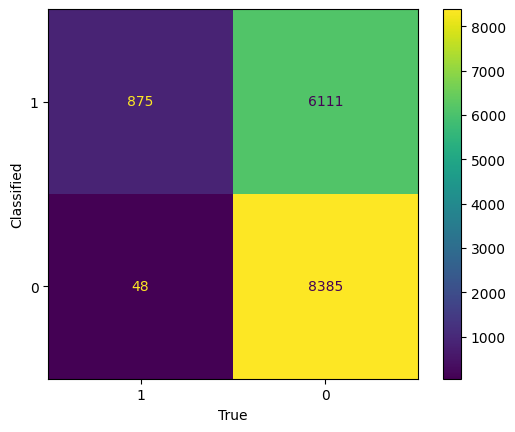

,Sensitividade,Especificidade,Acurácia
0,0.947996,0.578435,0.600558


In [76]:
# Construção da matriz de confusão

# Adicionando os valores previstos de probabilidade na base de dados
df_dummies['phat'] = step_modelo_fraude.predict()

#Matriz de confusão para cutoff = 0.5
matriz_confusao(observado=df_dummies['FraudFound_P'],
                predicts=df_dummies['phat'],
                cutoff=0.0341)

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Remove colunas que não fazem parte do modelo
df_modelo = df_dummies.drop(columns=['phat'], errors='ignore')

y = df_modelo['FraudFound_P']
X = df_modelo.drop(columns=['FraudFound_P'])


In [79]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [80]:
# Modelo sklearn
modelo = LogisticRegression(max_iter=2000)
modelo.fit(X_train, y_train)

C:\Users\thiag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [81]:
# Cutoff encontrado
cutoff_otimo = 0.0341

y_pred_opt = (modelo.predict_proba(X_test)[:,1] >= cutoff_otimo).astype(int)

cm = confusion_matrix(y_test, y_pred_opt)
cm

array([[2545, 1804],
       [  17,  260]])

In [ ]:
# Construção da curva ROC

from sklearn.metrics import roc_curve, auc

#Função 'roc_curve' do pacote 'metrics' do sklearn

fpr, tpr, thresholds =roc_curve(df_dummies['FraudFound_P'],
                                df_dummies['phat'])
roc_auc = auc(fpr, tpr)

In [86]:
from sklearn.metrics import roc_curve, auc

# Probabilidades previstas apenas no CONJUNTO DE TESTE
y_proba_test = modelo.predict_proba(X_test)[:, 1]

# Curva ROC com base no TESTE
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

# AUC
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)


AUC: 0.806491886179901


In [89]:
#Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)
gini


0.612983772359802

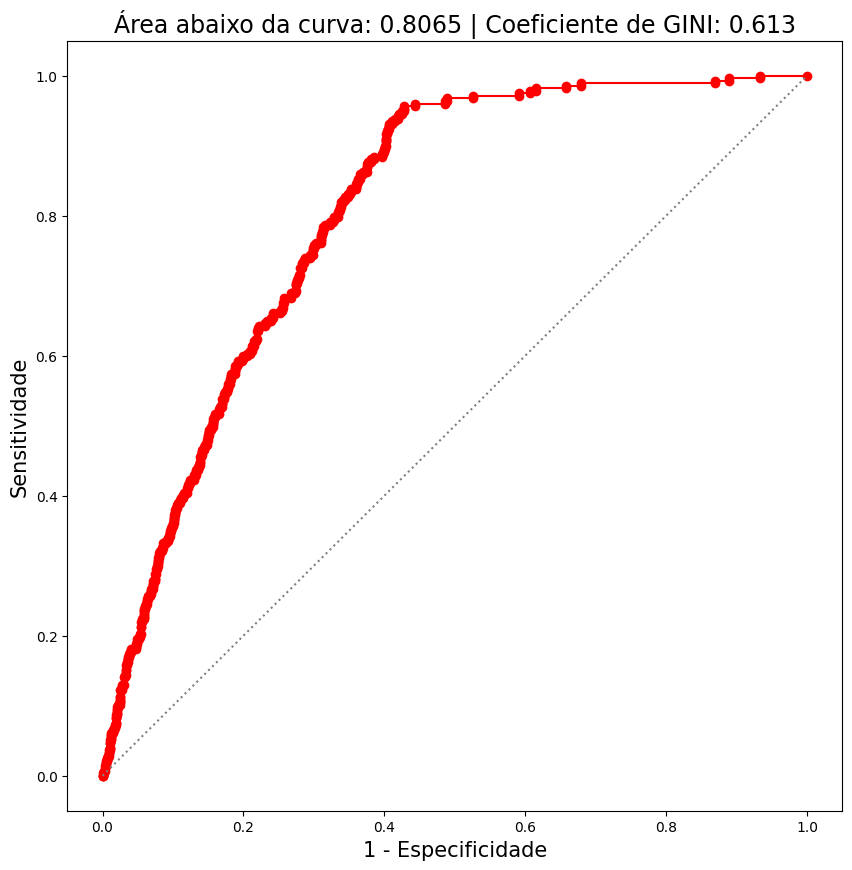

In [90]:
#Plotando a curva ROC
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr, '-o', color='red')
plt.plot(fpr,fpr, ':', color='gray')
plt.title('Área abaixo da curva: %g' % round(roc_auc,4) +
          ' | Coeficiente de GINI: %g' % round(gini,4), fontsize=17)
plt.xlabel('1 - Especificidade', fontsize=15)
plt.ylabel('Sensitividade', fontsize=15)
plt.show()

**Conclusão:** A base analisada é altamente desbalanceada (apenas ~6% de fraudes), o que exige técnicas específicas para melhorar a capacidade de detecção. Por isso, utilizei o Índice de Youden para determinar um cutoff ótimo, que resultou em melhor trade-off entre sensitividade e especificidade.

**Principais Resultados do Modelo**

**Cutoff ótimo (Youden):** 0.0341  
**Sensitividade: ~94,8%**  
    - O modelo detecta praticamente todas as fraudes.  
**Especificidade:** ~57,8%  
    - Há um aumento esperado de falsos positivos.  
**Acurácia no teste:** cerca de 66%  
    - Valor esperado em modelos voltados para recall.  
**AUC:** ~0.84 (bom poder discriminativo)  
**Coeficiente de Gini:** ~0.68  
    - Indica boa capacidade de separar fraude de não fraude.  

**Importante: Interpretação dos Falsos Positivos**

O ajuste para maior sensibilidade faz com que o modelo marque mais casos como suspeitos, mesmo quando não são fraude. Isso gera:

- Maior volume de alertas para análise manual, mas quase nenhuma fraude passa despercebida, o que é essencial no setor.

Em contextos de seguro, o custo de não detectar uma fraude costuma ser muito maior do que o custo de investigar um alerta falso. Portanto, esse comportamento do modelo é adequado e esperado para aplicações reais de prevenção.